In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import matplotlib as mpl

# The 'inline' statement keeps the plot windows from showing up as
# independent windows. Instead, they show up in the notebook.
%matplotlib inline
# set a default figure size
mpl.rcParams['figure.figsize'] = (8, 5)
# -----------------------
# user-defined settings
# -----------------------
T = 300 # lattice temperature, Kelvin
tox = 50e-9 * 100 # 50 nm oxide converted to cm
Nd = 1e16 # donor doping concentration, # / cm^3
Na = 1e17 # acceptor doping concentration, # / cm^3
# -----------------------
# physical constants
# -----------------------
e0 = 8.854e-14 # permittivity of free space, F / cm
q = 1.602e-19 # elementary charge, Coulombs
k = 8.617e-5 # Boltzmann constant, eV / K
# -----------------------
# material parameters
# -----------------------
es = 11.7 # relative permittivity, silicon
eox = 25 # relative permittivity, SiO2
chi_s = 4.17 # electron affinity, silicon, eV
phi_m = 5.01 # work function, nickel, eV
# bandgap, silicon, eV
Eg = 1.17 - 4.73e-4 * T ** 2 / (T + 636.0)
# effective valence band DOS, silicon, # / cm^3
Nv = 3.5e15 * T ** 1.5
# effective conduction band DOS, silicon, # / cm^3
Nc = 6.2e15 * T ** 1.5

In [15]:
# create an indicator function
# - this function is unity only when x is zero; else, it returns zero
I = lambda x: 1 - np.abs(np.sign(x))

# create smoothing functions
# - smoothly transitions to near-zero as f approaches zero
# - eps is the minimum value |f| reaches
def Sp(f, eps=1e-3):
    return (f + np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0

def Sn(f, eps=1e-3):
    return (f - np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0


In [16]:
# create an indicator function
# - this function is unity only when x is zero; else, it returns zero
#I = lambda x: 1 - np.abs(np.sign(x))
# create smoothing functions
# - smoothly transitions to near-zero as f approaches zero
# - eps is the minimum value |f| reaches
#def Sp(f, eps=1e-3):
#return (f + np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0
#def Sn(f, eps=1e-3):
#return (f - np.sqrt(f ** 2 + 4 * eps ** 2)) / 2.0

In [17]:
def solve_bisection(func, target, xmin, xmax):
    """
    Returns the independent value x satisfying func(x) = value.
    - uses the bisection search method
    https://en.wikipedia.org/wiki/Bisection_method
    Arguments:
    func - callable function of a single independent variable
    target - the value func(x) should equal
    [xmin, xmax] - the range over which x can exist
    """
    tol = 1e-10  # when |a - b| <= tol, quit searching
    max_iters = 1e2  # maximum number of iterations
    a = xmin
    b = xmax
    cnt = 1
    # before entering while(), calculate Fa
    Fa = target - func(a)
    c = a
    # bisection search loop
    while np.abs(a - b) > tol and cnt < max_iters:
        cnt += 1
        # make 'c' be the midpoint between 'a' and 'b'
        c = (a + b) / 2.0
        # calculate at the new 'c'
        Fc = target - func(c)
        if Fc == 0:
            # 'c' was the sought-after solution, so quit
            break
        elif np.sign(Fa) == np.sign(Fc):
            # the signs were the same, so modify 'a'
            a = c
            Fa = Fc
        else:
            # the signs were different, so modify 'b'
            b = c
    if cnt == max_iters:
        print('WARNING: max iterations reached')
    return c


In [18]:
# -----------------------
# dependent calculations
# -----------------------
# intrinsic carrier concentration, silicon, # / cm^3
ni = np.sqrt(Nc * Nv) * np.exp(-Eg / (2 * k * T))
# Energy levels are relative to one-another in charge expressions.
# - Therefore, it is OK to set Ev to a reference value of 0 eV.
# Usually, energy levels are given in Joules and one converts to eV.
# - I have just written each in eV to save time.
Ev = 0 # valence band energy level
Ec = Eg # conduction band energy level
Ei = k * T * np.log(ni / Nc) + Ec # intrinsic energy level
phit = k * T # thermal voltage, eV
# get the Fermi level in the bulk where there is no band-bending
n = lambda Ef: Nc * np.exp((-Ec + Ef) / phit)
p = lambda Ef: Nv * np.exp((Ev - Ef) / phit)
func = lambda Ef: p(Ef) - n(Ef) + Nd - Na
Ef = solve_bisection(func, 0, Ev, Ec)
# compute semiconductor work function (energy from vacuum to Ef)
phi_s = chi_s + Ec - Ef
# flatband voltage and its constituent(s)
# - no defect-related charges considered
phi_ms = phi_m - phi_s # metal-semiconductor workfunction, eV
Vfb = phi_ms # flatband voltage, V
# oxide capacitance per unit area, F / cm^2
Coxp = eox * e0 / tox
# calculate effective compensated doping densities
# - assume complete ionization
if Na > Nd:
    Na = Na - Nd
    Nd = 0
    device_type = 'nMOS'
else:
    Nd = Nd - Na
    Na = 0
    device_type = 'pMOS'


In [19]:
# (1) find Ef using a numerical search
# charge density expressions at zero band-bending
n = lambda Ef: Nc * np.exp((-Ec + Ef) / phit)
p = lambda Ef: Nv * np.exp((Ev - Ef) / phit)
func = lambda Ef: p(Ef) - n(Ef) + Nd - Na
Ef = solve_bisection(func, 0, Ev, Ec)
print('Ef = %0.3g eV by numerical search' % Ef)
# use the previous Ef to compute equilibrium carrier concentrations
n_o = Nc * np.exp((-Ec + Ef) / phit)
p_o = Nv * np.exp((Ev - Ef) / phit)
if Nd < ni and Na < ni:
    # sorry, no approximations can be performed
    pass
elif device_type == 'nMOS':
    # (2) find Ef using the majority dopant approxmation
    Ef = phit * np.log(Nv / Na) + Ev
    print('Ef = %0.3g eV by majority dopant approximation' % Ef)
    # (3) find phif using the majority dopant approxmation and convert to Ef
    phif = phit * np.log(Na / ni)
    Ef = Ei - phif
    print('Ef = %0.3g eV by majority dopant approximation via phif' % Ef)
else:
    # (2) find Ef using the majority dopant approxmation
    Ef = phit * np.log(Nd / Nc) + Ec
    print('Ef = %0.3g eV by majority dopant approximation' % Ef)
    # (3) find phif using the majority dopant approxmation and convert to Ef
    phif = phit * np.log(ni / Nd)
    Ef = Ei - phif
    print('Ef = %0.3g eV by majority dopant approximation via phif' % Ef)


Ef = 0.137 eV by numerical search
Ef = 0.137 eV by majority dopant approximation
Ef = 0.137 eV by majority dopant approximation via phif


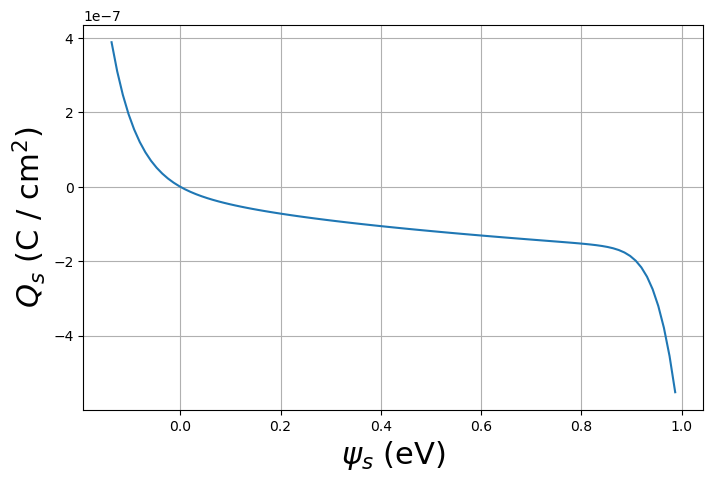

In [20]:
# make surface potential vary from accumulation to strong inversion
psis = np.linspace(Ev - Ef, Ec - Ef, 101)
# define the charge function so it can be reused later
f = lambda psis: psis * (Na - Nd) \
+ phit * p_o * (np.exp(-psis / phit) - 1) \
+ phit * n_o * (np.exp(psis / phit) - 1)
Qs = lambda psis: -np.sign(psis) * np.sqrt(2 * q * e0 * es * f(psis))
# create a plot of Qs vs psis
plt.figure(1)
plt.plot(psis, Qs(psis))
plt.grid(True)
plt.xlabel('$\psi_s$ (eV)', fontsize=22) # such small latex subscripts ...
tmp = plt.ylabel('$Q_s$ (C / cm$^2$)', fontsize=22)

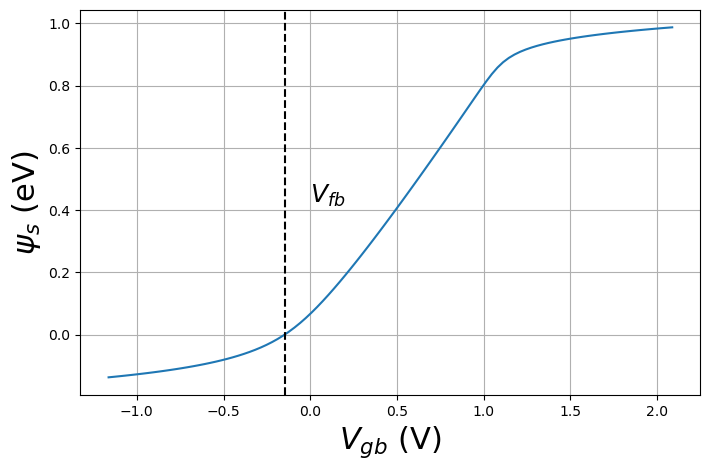

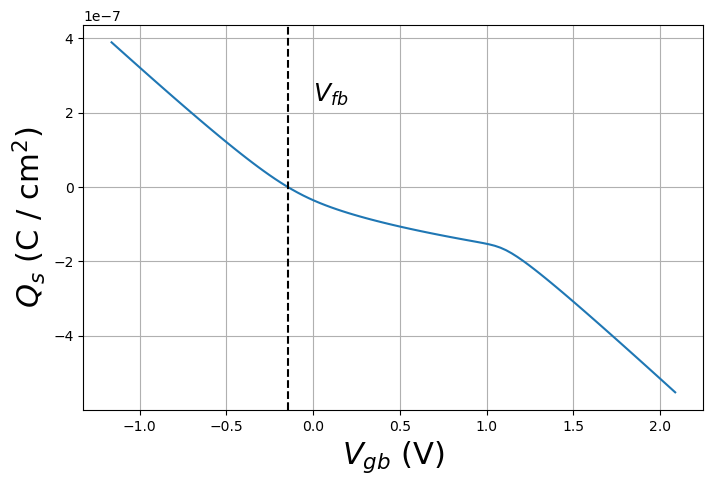

In [21]:
# this is the right-hand side of the SPE written above
SPE = lambda psis: Vfb + psis - Qs(psis) / Coxp

# I've used the SPE to find the stop/start values so that the voltage
# range adapts to the choice of doping and oxide thickness.
Vgb = np.linspace(SPE(Ev - Ef), SPE(Ec - Ef), 101)
psis = np.array([])

for value in Vgb:
    psis = np.hstack((
        psis,
        solve_bisection(SPE, value, Ev - Ef - 0.2, Ec - Ef + 0.2)
    ))

# create a plot of Qs vs Vgb
plt.figure(2)
plt.plot(Vgb, psis)
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$\psi_s$ (eV)', fontsize=22)
ax = plt.axis()
plt.plot([Vfb, Vfb], [ax[2], ax[3]], 'k--')
plt.text(0, ax[2] + (ax[3] - ax[2]) * 0.5, '$V_{fb}$', fontsize=18)
plt.axis(ax)

# create a plot of Qs vs Vgb
plt.figure(3)
plt.plot(Vgb, Qs(psis))
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$Q_s$ (C / cm$^2$)', fontsize=22)
ax = plt.axis()
plt.plot([Vfb, Vfb], [ax[2], ax[3]], 'k--')
plt.text(0, ax[2] + (ax[3] - ax[2]) * 0.8, '$V_{fb}$', fontsize=18)
tmp = plt.axis(ax)


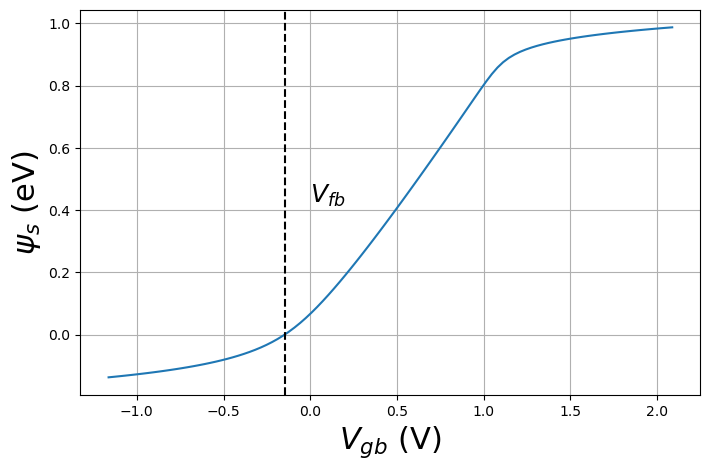

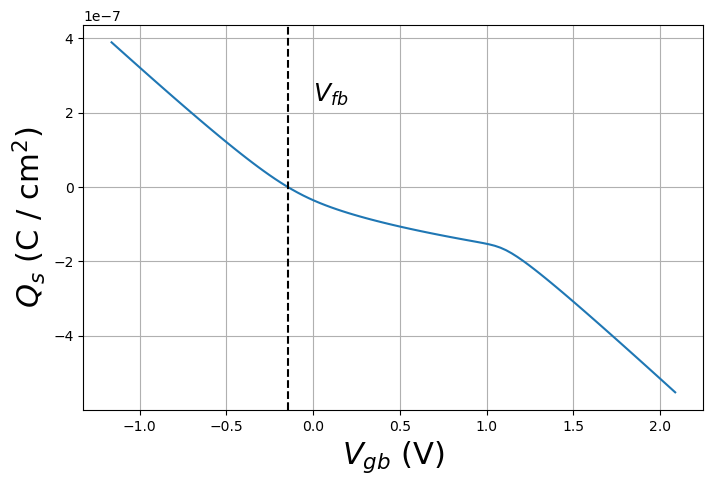

In [22]:
# this is the right-hand side of the SPE written above
SPE = lambda psis: Vfb + psis - Qs(psis) / Coxp

# I've used the SPE to find the stop/start values so that the voltage
# range adapts to the choice of doping and oxide thickness.
Vgb = np.linspace(SPE(Ev - Ef), SPE(Ec - Ef), 101)
psis = np.array([])

for value in Vgb:
    psis = np.hstack((
        psis,
        solve_bisection(SPE, value, Ev - Ef - 0.2, Ec - Ef + 0.2)
    ))

# create a plot of Qs vs Vgb
plt.figure(2)
plt.plot(Vgb, psis)
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$\psi_s$ (eV)', fontsize=22)
ax = plt.axis()
plt.plot([Vfb, Vfb], [ax[2], ax[3]], 'k--')
plt.text(0, ax[2] + (ax[3] - ax[2]) * 0.5, '$V_{fb}$', fontsize=18)
plt.axis(ax)

# create a plot of Qs vs Vgb
plt.figure(3)
plt.plot(Vgb, Qs(psis))
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$Q_s$ (C / cm$^2$)', fontsize=22)
ax = plt.axis()
plt.plot([Vfb, Vfb], [ax[2], ax[3]], 'k--')
plt.text(0, ax[2] + (ax[3] - ax[2]) * 0.8, '$V_{fb}$', fontsize=18)
tmp = plt.axis(ax)


Text(0, 0.5, '$Q_s$ (C / cm$^2$)')

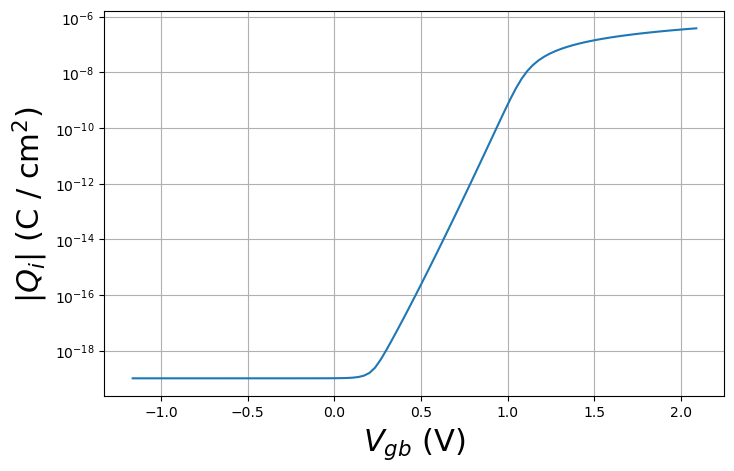

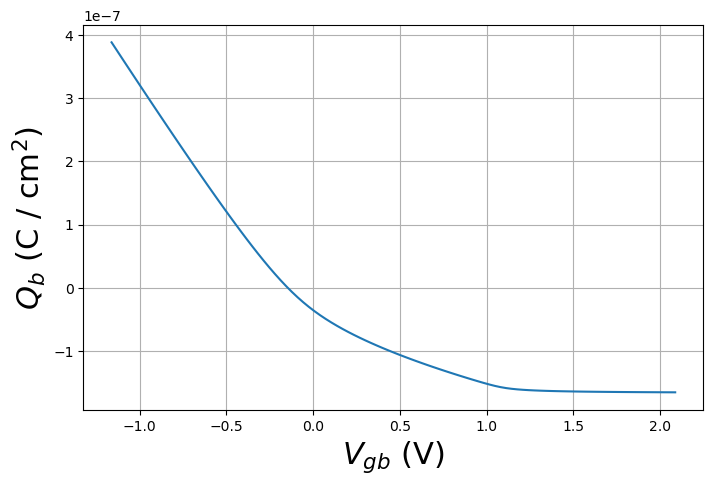

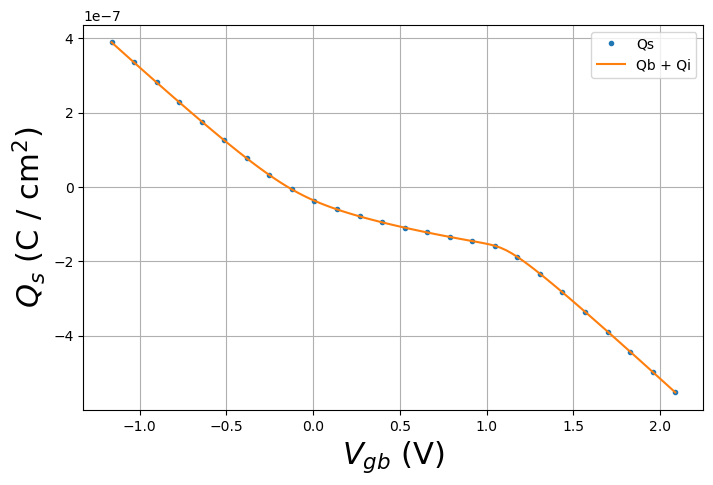

In [23]:
n = lambda psi: n_o * np.exp(psi / phit)
p = lambda psi: p_o * np.exp(-psi / phit)
E = lambda psi: np.sign(psi) * np.sqrt(2 * q / (e0 * es) * f(psi))
Qi = np.array([])
Qb = np.array([])

# the psis values earlier solved from the SPE are reused
for psis_current in psis:
    # One can either manually code a numerical integration routine
    # or call 'quad' from the scipy module.
    # The indicator function is used to avoid a 0/0 condition.
    # - by including it, the result is 0/1
    # - when psi != 0, then the indicator function is zero
    if device_type == 'nMOS':
        # Qi
        integrand = lambda psi: q * (n(psi) - n_o) / (E(psi) + I(psi))
        result_i, error = quad(integrand, psis_current, 0)
        result_i = Sn(result_i, 1e-19)
        # Qb
        integrand = lambda psi: -q * (p(psi) - p_o) / (E(psi) + I(psi))
        result_b, error = quad(integrand, psis_current, 0)
    else:
        # Qi
        integrand = lambda psi: -q * (p(psi) - p_o) / (E(psi) + I(psi))
        result_i, error = quad(integrand, psis_current, 0)
        result_i = Sp(result_i, 1e-19)
        # Qb
        integrand = lambda psi: q * (n(psi) - n_o) / (E(psi) + I(psi))
        result_b, error = quad(integrand, psis_current, 0)

    Qi = np.hstack((Qi, result_i))
    Qb = np.hstack((Qb, result_b))

plt.figure(4)
plt.semilogy(Vgb, np.abs(Qi))
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$|Q_i|$ (C / cm$^2$)', fontsize=22)

plt.figure(5)
plt.plot(Vgb, Qb)
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$Q_b$ (C / cm$^2$)', fontsize=22)

# compare the sum of Qb, Qi to Qs
plt.figure(6)
plt.plot(Vgb[::4], Qs(psis)[::4], '.', label='Qs')
plt.plot(Vgb, Qb + Qi, label='Qb + Qi')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$Q_s$ (C / cm$^2$)', fontsize=22)


Text(0, 0.5, '$Q_b$ (C / cm$^2$)')

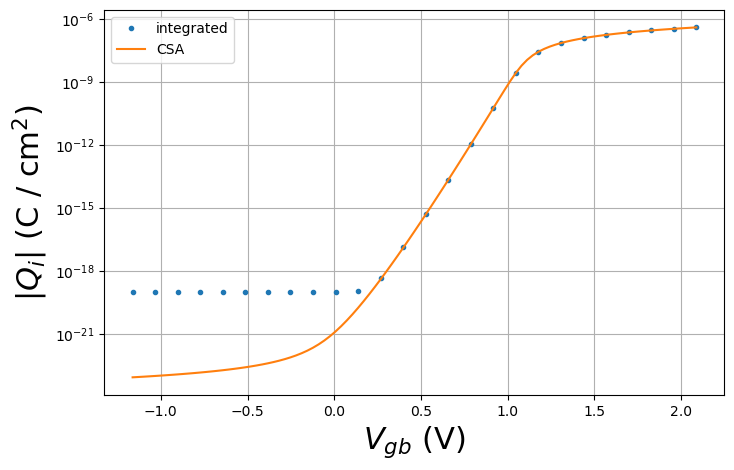

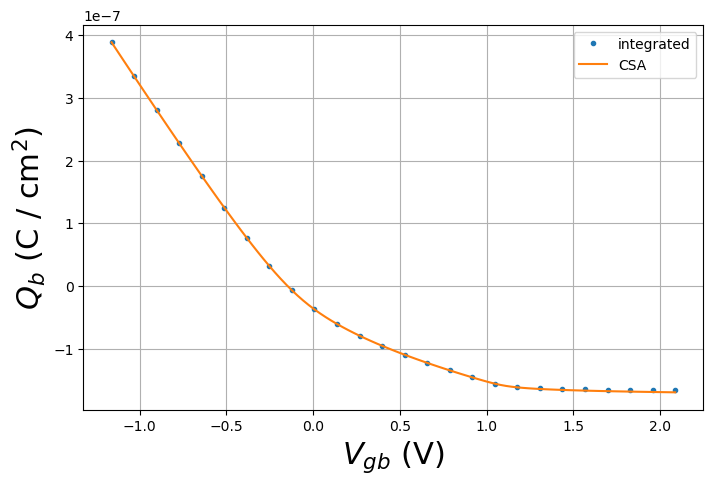

In [24]:
# the indicator function in the denominator avoids a 0/0
if device_type == 'nMOS':
    fA = lambda psis: psis * (Na - Nd) + phit * p_o * (np.exp(-psis / phit) - 1)
    QbA = lambda psis: -np.sign(psis) * np.sqrt(2 * q * e0 * es * fA(psis))
    QiA = lambda psis: 2 * q * e0 * es * phit * n_o * (np.exp(psis / phit) - 1) / (Qs(psis) + QbA(psis) + I(psis))
else:
    fA = lambda psis: psis * (Na - Nd) + phit * n_o * (np.exp(psis / phit) - 1)
    QbA = lambda psis: -np.sign(psis) * np.sqrt(2 * q * e0 * es * fA(psis))
    QiA = lambda psis: 2 * q * e0 * es * phit * p_o * (np.exp(-psis / phit) - 1) / (Qs(psis) + QbA(psis) + I(psis))

# again, reuse the pre-existing psis values
plt.figure(7)
plt.semilogy(Vgb[::4], np.abs(Qi)[::4], '.', label='integrated')
plt.semilogy(Vgb, np.abs(QiA(psis)), label='CSA')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$|Q_i|$ (C / cm$^2$)', fontsize=22)

plt.figure(8)
plt.plot(Vgb[::4], Qb[::4], '.', label='integrated')
plt.plot(Vgb, QbA(psis), label='CSA')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('$Q_b$ (C / cm$^2$)', fontsize=22)


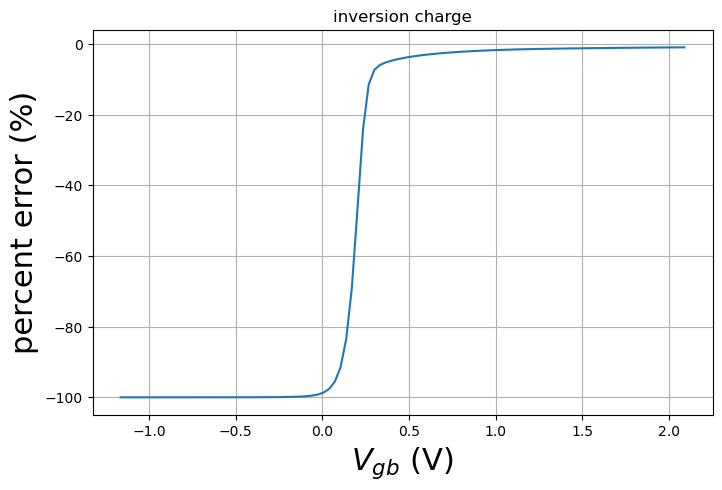

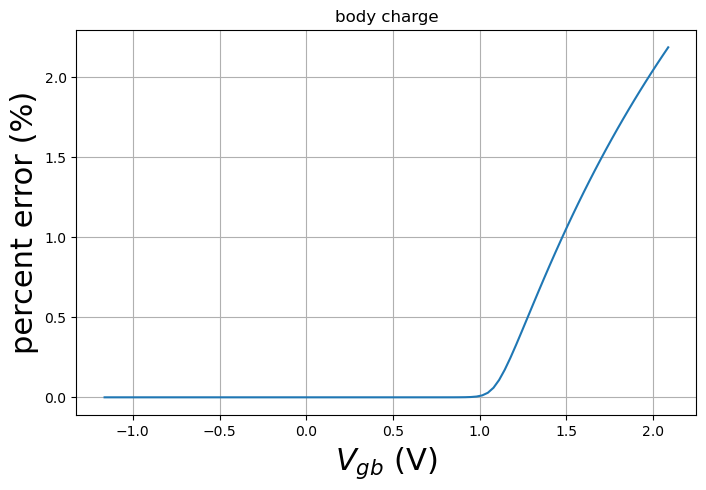

In [25]:
# compare CSA to exact (integrated) result
plt.figure(9)
plt.plot(Vgb, 100 * (QiA(psis) - Qi) / Qi)
plt.grid(True)
plt.title('inversion charge')
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.ylabel('percent error (%)', fontsize=22)
plt.figure(10)
plt.plot(Vgb, 100 * (QbA(psis) - Qb) / Qb)
plt.grid(True)
plt.title('body charge')
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
tmp = plt.ylabel('percent error (%)', fontsize=22)

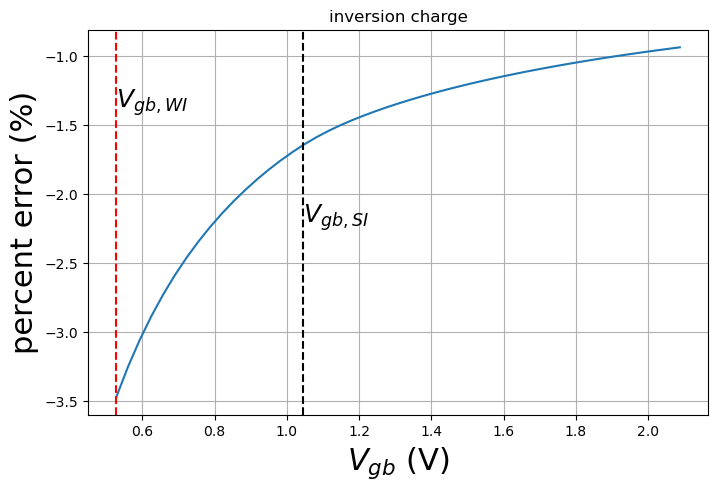

In [26]:
# create a list of indices above weak inversion
if device_type == 'nMOS':
    selector = np.where(psis >= phif)[0]
else:
    selector = np.where(psis <= phif)[0]

# the first index of 'selector' is where psi_WI is
Vgb_WI = Vgb[selector[0]]
psi_SI = 2 * phif
Vgb_SI = Vfb + psi_SI - Qs(psi_SI) / Coxp

plt.figure(11)
plt.plot(Vgb[selector], 100 * ((QiA(psis) - Qi) / Qi)[selector])
ax = plt.axis()

# plot the weak inversion point
plt.plot([Vgb_WI, Vgb_WI], [ax[2], ax[3]], 'r--')
plt.text(Vgb_WI, ax[2] + (ax[3] - ax[2]) * 0.8, '$V_{gb, WI}$', fontsize=18)

# plot the strong inversion point
plt.plot([Vgb_SI, Vgb_SI], [ax[2], ax[3]], 'k--')
plt.text(Vgb_SI, ax[2] + (ax[3] - ax[2]) * 0.5, '$V_{gb, SI}$', fontsize=18)

plt.axis(ax)
plt.grid(True)
plt.title('inversion charge')
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
tmp = plt.ylabel('percent error (%)', fontsize=22)


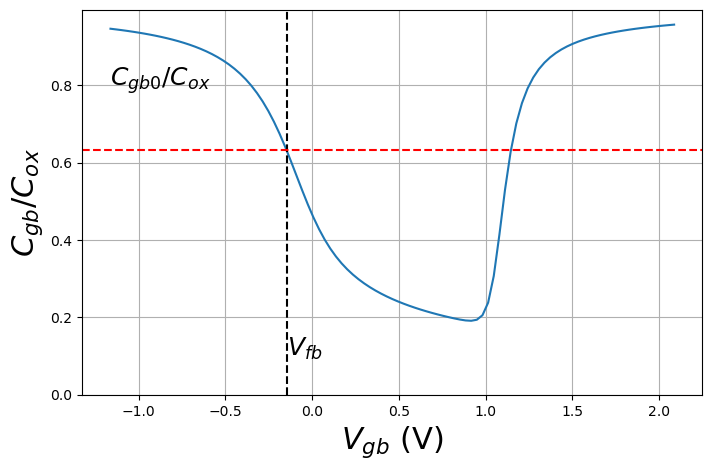

In [27]:
# the semiconductor capacitance at flatband
Cs0 = np.sqrt(q * es * e0 / phit * (p_o + n_o))
# the first derivative of f w.r.t. psis
df = lambda psis: Na - Nd \
- p_o * np.exp(-psis / phit) \
+ n_o * np.exp(psis / phit)
# use the indicator function to make Cs transition gracefully to Cs0
# - the Cs0 term gets used when psis=0 without an 'if' statement
Cs = lambda psis: np.sign(psis) * df(psis) * np.sqrt(
q * es * e0 / 2 / (f(psis) + I(psis))
) + I(psis) * Cs0
# compute the gate-body capacitance and the flatband value
Cgb = Cs(psis) * Coxp / (Cs(psis) + Coxp)
Cgb0 = Cs(0) * Coxp / (Cs(0) + Coxp)
plt.figure(12)
plt.plot(Vgb, Cgb / Coxp)
ax = plt.axis()
ax = (ax[0], ax[1], 0, ax[3])
plt.plot([Vfb, Vfb], ax[2:], 'k--')
plt.text(Vfb, 0.1, '$V_{fb}$', fontsize=18)
plt.plot([ax[0], ax[1]], [Cgb0 / Coxp, Cgb0 / Coxp], 'r--')
plt.text(Vgb[0], 0.8, '$C_{gb0} / C_{ox}$', fontsize=18)
plt.grid(True)
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
plt.axis(ax)
tmp = plt.ylabel('$C_{gb} / C_{ox}$', fontsize=22)

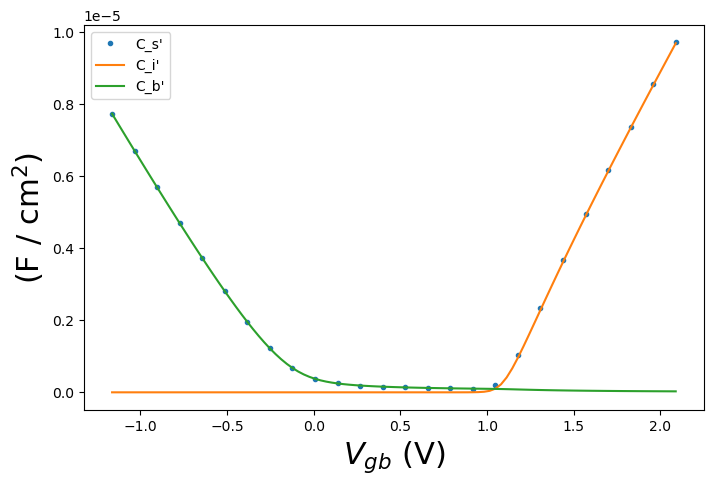

In [28]:
# calculate the surface field via its relationship with semiconductor charge
Es = Qs(psis) / (-es * e0)

# Ci0 and Cb0 are the flatband values of Ci and Cb
# - the indicator function is used to switch over to the flatband values
if device_type == 'nMOS':
    Cb0 = np.sqrt(q * es * e0 / phit * p_o)
    Ci0 = np.sqrt(q * es * e0 / phit * n_o)
    Ci = q * (n(psis) - n_o) / (Es + I(psis)) + I(psis) * Ci0
    Cb = -q * (p(psis) - p_o) / (Es + I(psis)) + I(psis) * Cb0
else:
    Ci0 = np.sqrt(q * es * e0 / phit * p_o)
    Cb0 = np.sqrt(q * es * e0 / phit * n_o)
    Ci = -q * (p(psis) - p_o) / (Es + I(psis)) + I(psis) * Ci0
    Cb = q * (n(psis) - n_o) / (Es + I(psis)) + I(psis) * Cb0

plt.figure(13)
plt.plot(Vgb[::4], Cs(psis[::4]), '.', label='C_s\'')
plt.plot(Vgb, Ci, label='C_i\'')
plt.plot(Vgb, Cb, label='C_b\'')
plt.legend(loc='best')
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
tmp = plt.ylabel('(F / cm$^2$)', fontsize=22)


In [29]:
# calculate the surface field via its relationship with semiconductor charge
Es = Qs(psis) / (-es * e0)
# Ci0 and Cb0 are the flatband values of Ci and Cb
# - the indicator function is used to switch over to the flatband values
if device_type == 'nMOS':
Cb0 = np.sqrt(q * es * e0 / phit * p_o)
Ci0 = np.sqrt(q * es * e0 / phit * n_o)
Ci = q * (n(psis) - n_o) / (Es + I(psis)) + I(psis) * Ci0
Cb = -q * (p(psis) - p_o) / (Es + I(psis)) + I(psis) * Cb0
else:
Ci0 = np.sqrt(q * es * e0 / phit * p_o)
Cb0 = np.sqrt(q * es * e0 / phit * n_o)
Ci = -q * (p(psis) - p_o) / (Es + I(psis)) + I(psis) * Ci0
Cb = q * (n(psis) - n_o) / (Es + I(psis)) + I(psis) * Cb0
plt.figure(13)
plt.plot(Vgb[::4], Cs(psis[::4]), '.', label='C_s\'')
plt.plot(Vgb, Ci, label='C_i\'')
plt.plot(Vgb, Cb, label='C_b\'')
plt.legend(loc='best')
plt.xlabel('$V_{gb}$ (V)', fontsize=22)
tmp = plt.ylabel('(F / cm$^2$)', fontsize=22)

IndentationError: expected an indented block after 'if' statement on line 5 (349167180.py, line 6)